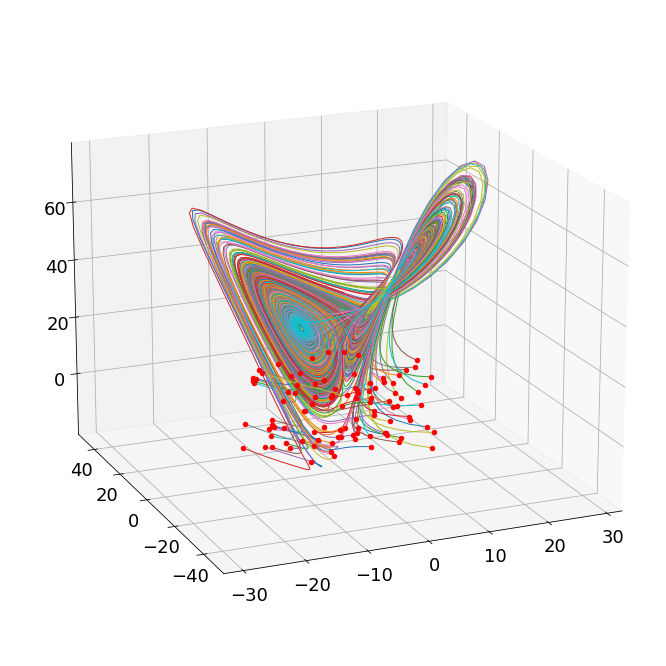

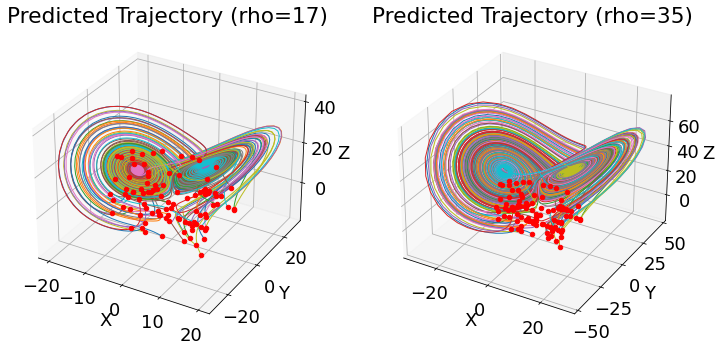

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

dt = 0.01
T = 8
t = np.arange(0, T + dt, dt)
beta = 8/3
sigma = 10
rho_values = [10, 28, 40, 17, 35]

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
    x, y, z = x_t[j, :, :].T
    ax.plot(x, y, z, linewidth=1)
    ax.scatter(x0[j, 0], x0[j, 1], x0[j, 2], color='r')

ax.view_init(18, -113)
plt.show()

X_train, X_val, y_train, y_val = train_test_split(nn_input, nn_output, test_size=0.2, random_state=123)

model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=123)
model.fit(X_train, y_train)

rho_values = [17, 35]
predicted_trajectories = []

for rho in rho_values:
    def lorenz_deriv_pred(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    predicted_x_t = np.asarray([integrate.odeint(lorenz_deriv_pred, x0_j, t)
                                for x0_j in x0])

    predicted_trajectories.append(predicted_x_t)

# Plot the predicted trajectories for rho = 17 and rho = 35
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
titles = ['Predicted Trajectory (rho=17)', 'Predicted Trajectory (rho=35)']

for i, rho in enumerate(rho_values):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].set_zlabel('Z')

    for j in range(100):
        x, y, z = predicted_trajectories[i][j, :, :].T
        ax[i].plot(x, y, z, linewidth=1)
        ax[i].scatter(x0[j, 0], x0[j, 1], x0[j, 2], color='r')

plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from scipy import integrate

# Prepare the data
dt = 0.01
T = 8
t = np.arange(0, T + dt, dt)
beta = 8/3
sigma = 10
rho = 28

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)

for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(nn_input, nn_output, test_size=0.2, random_state=123)

# Feed-forward Neural Network
model_ffnn = Sequential()
model_ffnn.add(Dense(64, activation='relu', input_shape=(3,)))
model_ffnn.add(Dense(64, activation='relu'))
model_ffnn.add(Dense(3))
model_ffnn.compile(loss='mean_squared_error', optimizer='adam')
model_ffnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(1, 3)))
model_lstm.add(Dense(3))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(np.expand_dims(X_train, axis=1), y_train, epochs=100, batch_size=32, verbose=0)

# RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, activation='relu', input_shape=(1, 3)))
model_rnn.add(Dense(3))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(np.expand_dims(X_train, axis=1), y_train, epochs=100, batch_size=32, verbose=0)


# Evaluate the models
ffnn_predictions = model_ffnn.predict(X_test)
lstm_predictions = model_lstm.predict(np.expand_dims(X_test, axis=1))
rnn_predictions = model_rnn.predict(np.expand_dims(X_test, axis=1))

ffnn_mse = mean_squared_error(y_test, ffnn_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)

# Print the mean squared error for each model
print("Mean Squared Error (Feed-forward Neural Network):", ffnn_mse)
print("Mean Squared Error (LSTM):", lstm_mse)
print("Mean Squared Error (RNN):", rnn_mse)

500/500 [==============================] - 2s 3ms/step
Mean Squared Error (Feed-forward Neural Network): 0.0008374579289053566
Mean Squared Error (LSTM): 0.001317690751113091
Mean Squared Error (RNN): 0.0011785174668981252
